In [221]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
import re, string
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [222]:
train = pd.read_csv('train.csv')

In [223]:
# Choose 10% data as validation data
validation = train.sample(frac=0.1, replace=False, weights=None, random_state=None, axis=None)
validation.head()

,qid,question_text,target
945895,b95ba08f7f24df892610,What is the best way to find the best interest inside me?,0
699884,89086c08eb6395c91e83,"It can be possible one day, what if there is one medicine for one disease in one body?",0
731124,8f2dc455b35051cb7339,Which is the best organisation to buy B2C mailing lists?,0
282007,3733b55308bed431f399,"What am I called if I worship nature, not nature deity's but just nature itself?",0
748819,92b3ebcba53c2d8cefdc,What proof is there that North Korea has Nukes?,0


In [224]:
train = train[~train.index.isin(validation.index)]
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
6,00005059a06ee19e11ad,"Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?",0


In [225]:
# cleaning insignificant symbols
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’""])')

In [226]:
# Tokenize function
def tokenize(s): 
    s= re.sub('[^a-zA-Z0-9]'," ",s)
    tokens=re_tok.sub(r' \1',s).split()
    return tokens

In [227]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize_nonstem,
                     min_df=3, max_df=0.9, strip_accents='unicode',
                     use_idf=1, smooth_idf=1, sublinear_tf=1)

In [228]:
# Calculate TF-IDF weight
trn_term_doc = vec.fit_transform(train['question_text'])
val_term_doc = vec.transform(validation['question_text'])

In [229]:
x = trn_term_doc
x_val = val_term_doc

In [230]:
# Generate a Logistic Regression model
def get_model(y):
    y = y.values
    m = LogisticRegression(C=4, dual=False,solver='liblinear')    
    return m.fit(x, y)

In [237]:
preds = np.zeros((len(validation), 1))
labels_cols=['target']

In [238]:
# for i, j in enumerate(labels_cols):
#     print('fit', j)
m= get_model(train['target'])
preds = m.predict_proba(x_val)[:,1]

In [259]:
y_true = validation['target'].values
y_score = preds
fpr, tpr, thresholds=roc_curve(y_true,y_score)
roc_auc =auc(fpr, tpr) 
roc_auc

0.9566489275184126

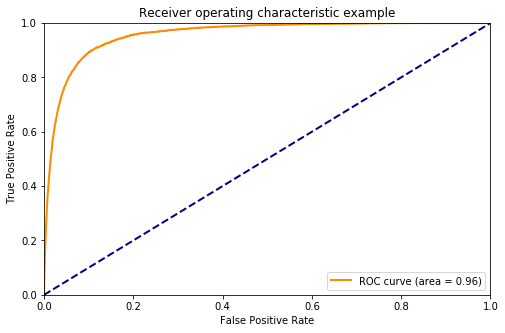

In [240]:
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [241]:
result = np.zeros((len(validation), 1))

In [290]:
for i in range(len(preds)):
    if preds[i] > 0.47:
        result[i]=1
    else:
        result[i]=0

In [291]:
# Calculate precision
val=validation['target'].values
val.reshape(preds.shape)
temp=0
for i in range(len(val)):
    if result[i]==val[i]:
        temp+=1
precision = temp/len(val)
precision

0.9553014553014553

In [324]:
result_2 = np.zeros((len(validation), 1))

In [325]:

for i in range(len(preds)):
    if preds[i] > 0.25:
        result_2[i]=1
    else:
        result_2[i]=0
# Calculate F1 score
b=np.sum(result_2)
a = np.sum(val)
c=0
for i in range(len(val)):
    if result_2[i]==1 and val[i]==1:
        c+=1
precision = c / b
recall = c / a
f1_score = 2 * precision * recall / (precision + recall)
f1_score

0.6330189358485132